## DIGITAL IMAGE PROCESSING PROJECT: JPEG COMPRESSION
### Coding and Visualisation Team:
1. Syed Jawad Haider Naqvi-----21L-7509     (BCS-6B)
2. Hassaan Mustafavi---------------21L-1849  (BCS-6A)

### Decoding and JPEG Format Image generation
1. Abdullah Arham------------21L-5265 (BCS-6A)
2. Hannan Fareed--------------21L-5392 (BCS-6A)



##For Grayscale Images

Starting JPEG compression workflow on 1.jpg
Loading image: 1.jpg


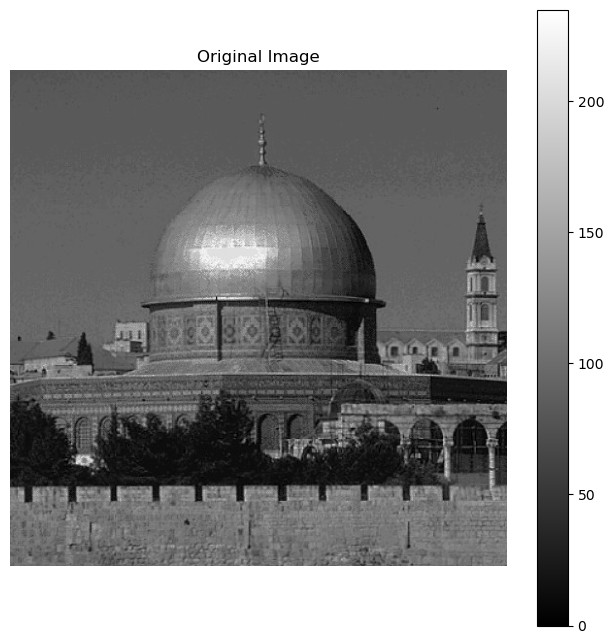

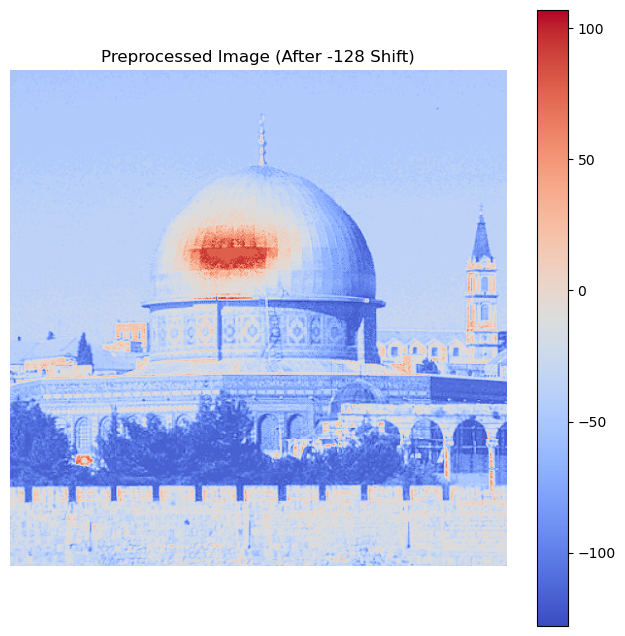

Saved preprocessed image visualization to .\preprocessed_image.jpg
Saved grayscale image to .\gray_lena.jpg
Image dimensions: 512x512
Saved DCT coefficients to .\dct_coefficients.txt


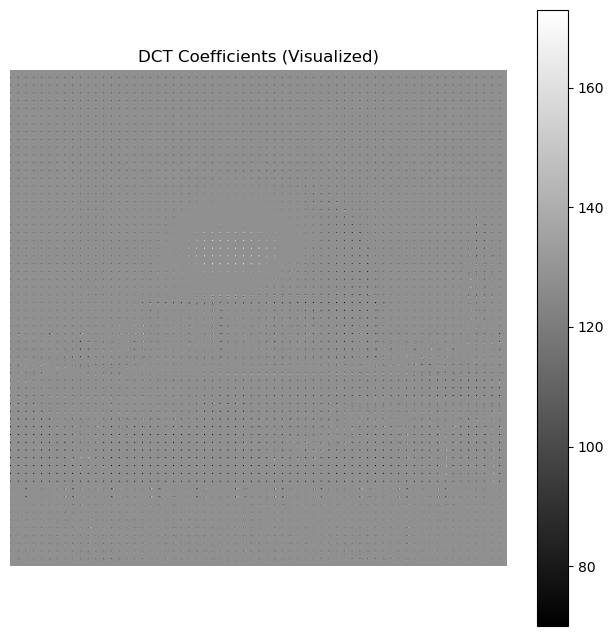

Saved DCT visualization to .\dct_visualized.jpg

Compression Statistics:
Total pixels: 262144
Non-zero DCT coefficients: 31803 (12.13%)
Estimated compression ratio: 4.06:1

Decompressing image...
Decompressing image from DCT coefficients


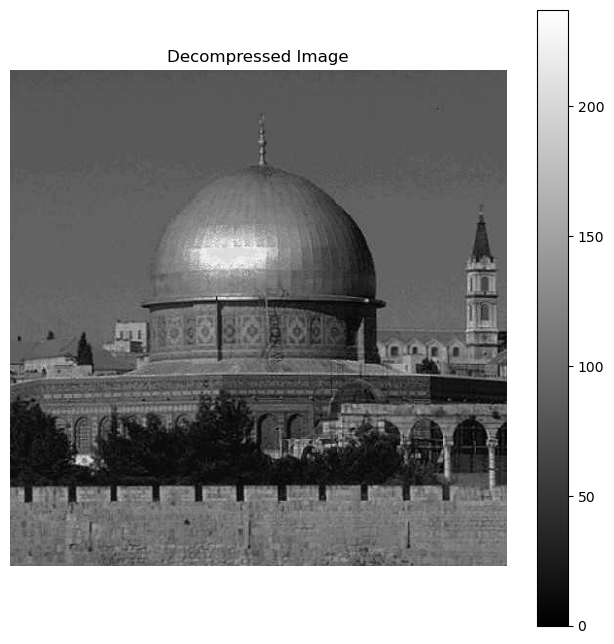

Saved decompressed image to decompressed_lena.jpg

JPEG compression workflow completed successfully!


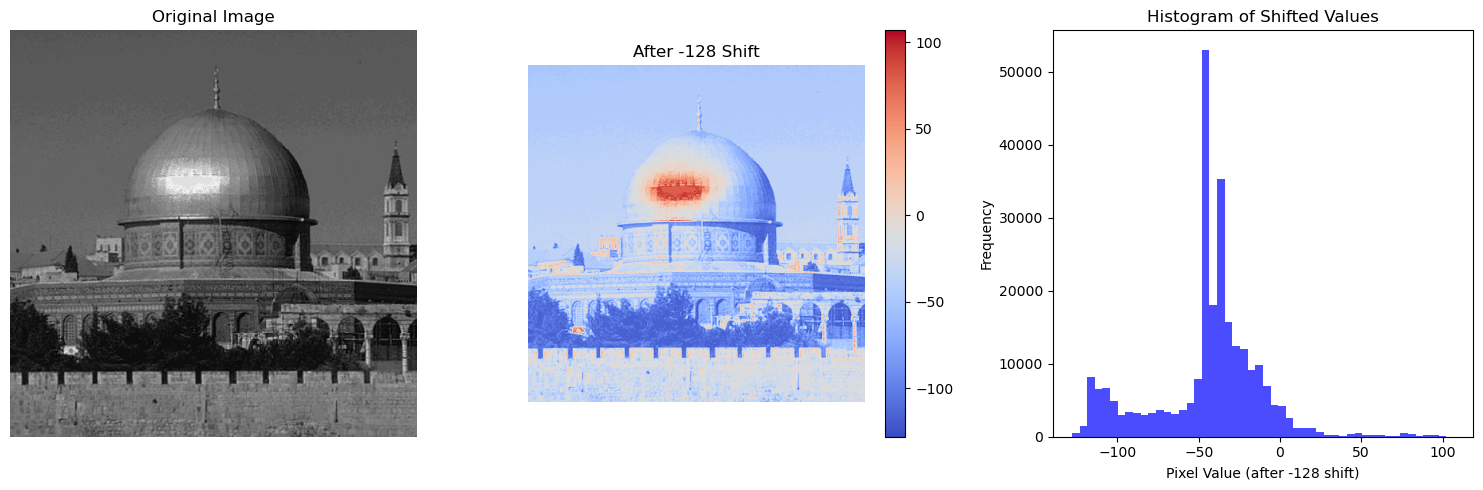

In [4]:
import numpy as np
from PIL import Image
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
import os

# Define the quantization matrix used in JPEG
Z = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# Display an image for debugging
def display_image(img_array, title="Image", cmap='gray'):
    plt.figure(figsize=(8, 8))
    plt.imshow(img_array, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.colorbar()
    plt.show()

# Function to apply DCT and quantization to an 8x8 block
def dct2(block):
    # Ensure the block is 8x8
    if block.shape[0] < 8 or block.shape[1] < 8:
        padded = np.zeros((8, 8))
        padded[:block.shape[0], :block.shape[1]] = block
        block = padded

    # Shift values by -128
    shifted = block - 128

    # Apply 2D DCT
    dct_applied = dct(dct(shifted, axis=0, norm='ortho'), axis=1, norm='ortho')

    # Quantize the coefficients
    quantized = np.round(dct_applied / Z)

    return quantized, shifted

# Function to perform inverse DCT and dequantization
def idct2(quantized_block):
    # Dequantize by multiplying with the quantization matrix
    dequantized = quantized_block * Z

    # Apply inverse 2D DCT
    idct_applied = idct(idct(dequantized, axis=0, norm='ortho'), axis=1, norm='ortho')

    # Shift back by adding 128 and clip to valid range [0, 255]
    result = np.clip(idct_applied + 128, 0, 255)

    return result

# Function to compress an image using JPEG-like process
def compress_image(image_path, output_dir="."):
    print(f"Loading image: {image_path}")

    # Load and convert image to grayscale
    img = Image.open(image_path)
    img = img.convert('L')

    # Display original image
    img_array = np.array(img, dtype=np.float32)
    display_image(img_array, "Original Image")

    # Create and display the preprocessed image (after -128 shift)
    preprocessed = img_array - 128
    display_image(preprocessed, "Preprocessed Image (After -128 Shift)", cmap='coolwarm')

    # Save visualization of preprocessed image
    preprocessed_vis = ((preprocessed + 128) / 255 * 255).astype(np.uint8)  # Scale for visualization
    preprocessed_path = os.path.join(output_dir, "preprocessed_image.jpg")
    Image.fromarray(preprocessed_vis).save(preprocessed_path)
    print(f"Saved preprocessed image visualization to {preprocessed_path}")

    # Save grayscale image
    gray_path = os.path.join(output_dir, "gray_lena.jpg")
    img.save(gray_path)
    print(f"Saved grayscale image to {gray_path}")

    # Get dimensions
    height, width = img_array.shape
    print(f"Image dimensions: {height}x{width}")

    # Initialize result matrix for DCT coefficients
    dct_result = np.zeros((height, width), dtype=np.float32)
    preprocessed_result = np.zeros((height, width), dtype=np.float32)

    # Process each 8x8 block
    for i in range(0, height, 8):
        for j in range(0, width, 8):
            # Get the current block (handling boundaries)
            i_end = min(i + 8, height)
            j_end = min(j + 8, width)
            block = img_array[i:i_end, j:j_end]

            # Apply DCT and quantization (now returns both quantized dct and shifted block)
            dct_block, shifted_block = dct2(block)

            # Store in results
            dct_result[i:i_end, j:j_end] = dct_block[:i_end-i, :j_end-j]
            preprocessed_result[i:i_end, j:j_end] = shifted_block[:i_end-i, :j_end-j]

    # Save DCT coefficients
    dct_path = os.path.join(output_dir, "dct_coefficients.txt")
    np.savetxt(dct_path, dct_result, fmt="%d")
    print(f"Saved DCT coefficients to {dct_path}")

    # Visualize DCT coefficients (scaled for visibility)
    dct_vis = np.clip((dct_result + 128), 0, 255).astype(np.uint8)
    display_image(dct_vis, "DCT Coefficients (Visualized)")

    dct_img_path = os.path.join(output_dir, "dct_visualized.jpg")
    Image.fromarray(dct_vis).save(dct_img_path)
    print(f"Saved DCT visualization to {dct_img_path}")

    return dct_result, preprocessed_result

# Function to decompress an image from DCT coefficients
def decompress_image(dct_coefficients, output_path="decompressed.jpg"):
    print("Decompressing image from DCT coefficients")

    # Get dimensions
    height, width = dct_coefficients.shape

    # Initialize array for restored image
    restored = np.zeros((height, width), dtype=np.float32)

    # Process each 8x8 block
    for i in range(0, height, 8):
        for j in range(0, width, 8):
            # Get the current block (handling boundaries)
            i_end = min(i + 8, height)
            j_end = min(j + 8, width)

            # Extract block of DCT coefficients
            block = np.zeros((8, 8))
            block[:i_end-i, :j_end-j] = dct_coefficients[i:i_end, j:j_end]

            # Apply inverse DCT and dequantization
            idct_block = idct2(block)

            # Store in result
            restored[i:i_end, j:j_end] = idct_block[:i_end-i, :j_end-j]

    # Clip values to valid pixel range and convert to uint8
    restored = np.clip(restored, 0, 255).astype(np.uint8)

    # Display decompressed image
    display_image(restored, "Decompressed Image")

    # Save decompressed image
    Image.fromarray(restored).save(output_path)
    print(f"Saved decompressed image to {output_path}")

    return restored

# Function to simulate Huffman encoding (without actual implementation)
def simulate_compression_stats(dct_coefficients):
    # Count non-zero coefficients
    non_zeros = np.count_nonzero(dct_coefficients)
    total_pixels = dct_coefficients.size

    # Calculate percentage of non-zero coefficients
    non_zero_percent = (non_zeros / total_pixels) * 100

    # Estimate compression ratio based on typical JPEG behavior
    # This is a simplified estimate based on the percentage of non-zero coefficients
    # Real JPEG compression would involve entropy coding and more complex statistics
    compression_ratio = 8 / (1 + non_zero_percent / 100 * 8)

    return {
        "total_pixels": total_pixels,
        "non_zero_coefficients": non_zeros,
        "non_zero_percent": non_zero_percent,
        "estimated_compression_ratio": compression_ratio
    }

# Main function to run the workflow
def main(image_path):
    print(f"Starting JPEG compression workflow on {image_path}")

    # Step 1: Compress image (DCT + Quantization)
    dct_coefficients, preprocessed = compress_image(image_path)

    # Step 2: Simulate compression statistics
    stats = simulate_compression_stats(dct_coefficients)
    print("\nCompression Statistics:")
    print(f"Total pixels: {stats['total_pixels']}")
    print(f"Non-zero DCT coefficients: {stats['non_zero_coefficients']} ({stats['non_zero_percent']:.2f}%)")
    print(f"Estimated compression ratio: {stats['estimated_compression_ratio']:.2f}:1")

    # Step 3: Decompress image
    print("\nDecompressing image...")
    restored_image = decompress_image(dct_coefficients, "decompressed_lena.jpg")

    print("\nJPEG compression workflow completed successfully!")
    return dct_coefficients, preprocessed, restored_image

# Check if lena.jpg exists, otherwise use any .jpg file in the directory
image_path = "1.jpg"
if not os.path.exists(image_path):
    print(f"Warning: {image_path} not found!")
    jpg_files = [f for f in os.listdir(".") if f.lower().endswith(".jpg")]
    if jpg_files:
        image_path = jpg_files[0]
        print(f"Using {image_path} instead.")
    else:
        print("No .jpg files found. Please upload an image.")
        raise FileNotFoundError("No suitable image file found")

# Run the main workflow
dct_coefficients, preprocessed, restored_image = main(image_path)

# Add an additional visualization to show the effect of preprocessing clearly
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
img = Image.open(image_path).convert('L')
img_array = np.array(img)
plt.imshow(img_array, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Preprocessed image (-128)
plt.subplot(1, 3, 2)
plt.imshow(preprocessed, cmap='coolwarm')
plt.title("After -128 Shift")
plt.axis('off')
plt.colorbar()

# Histogram of preprocessed values
plt.subplot(1, 3, 3)
plt.hist(preprocessed.flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Histogram of Shifted Values")
plt.xlabel("Pixel Value (after -128 shift)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

##For Handling RGB Color Channels to restored coloured images after decompression

Starting JPEG compression workflow on 1.jpg
Analyzing original image...


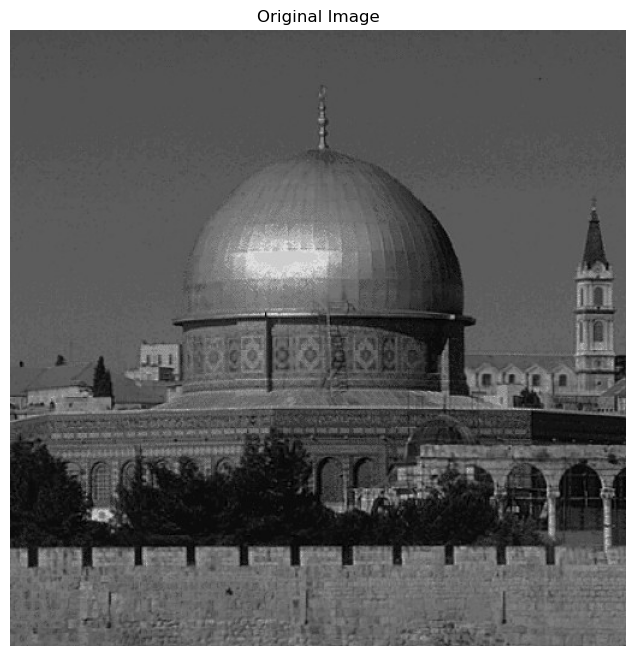

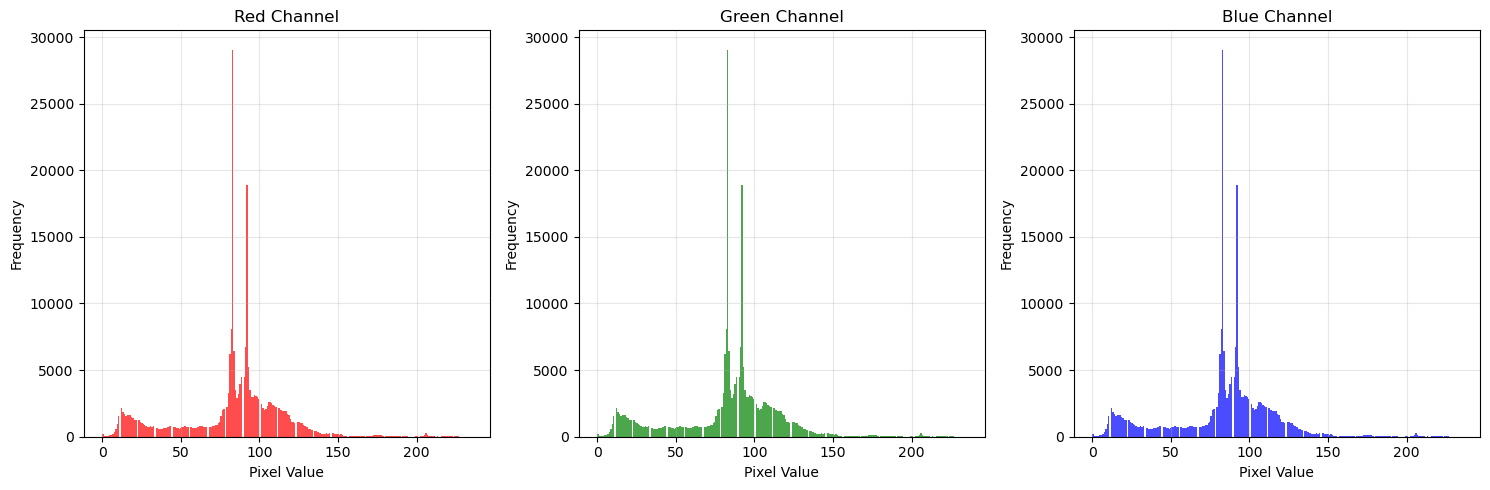

Visualizing pixel shifting (subtract 128)...


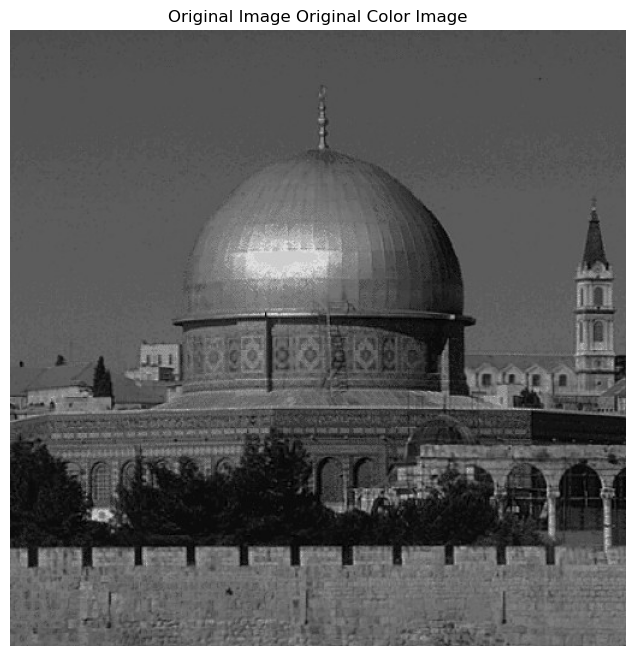

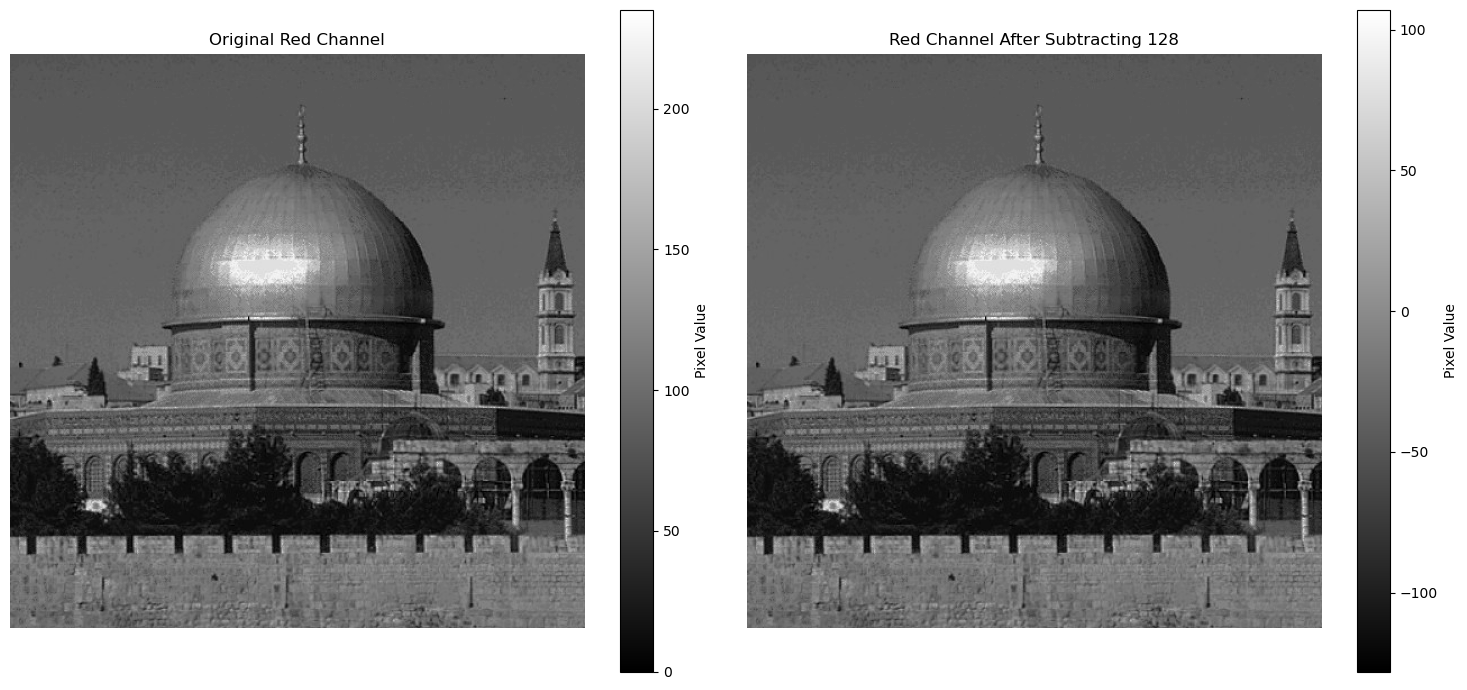

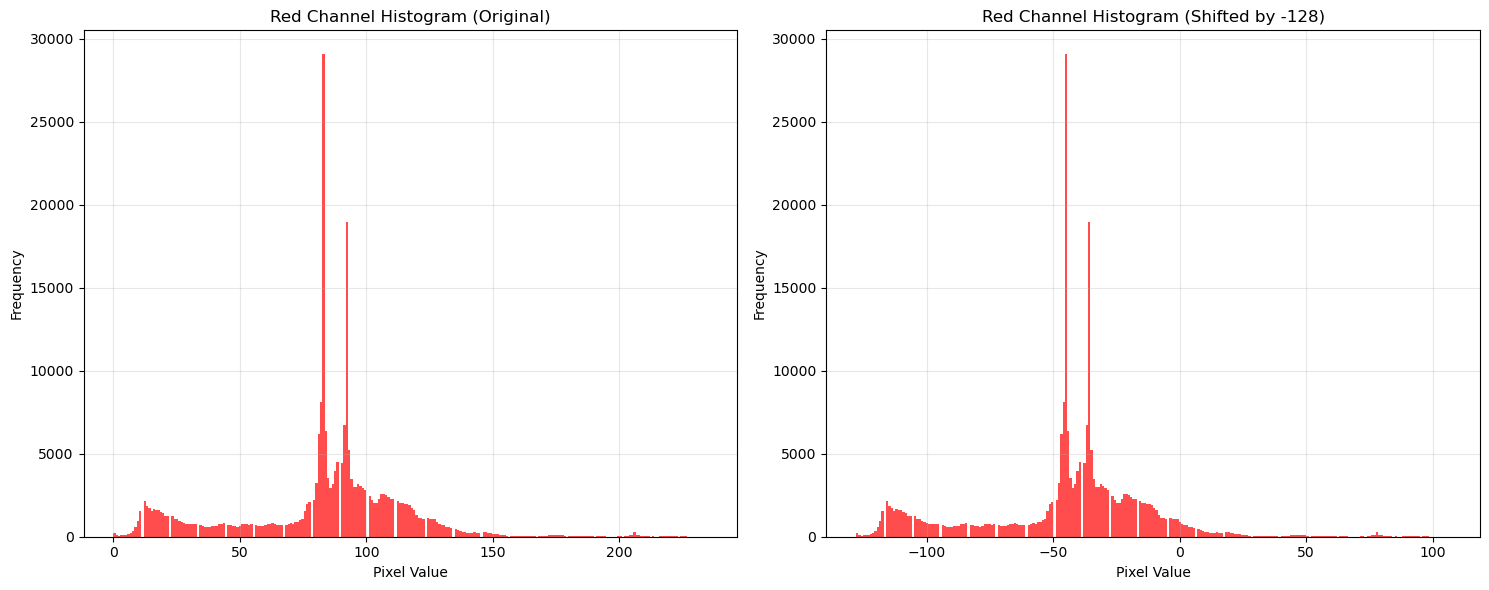

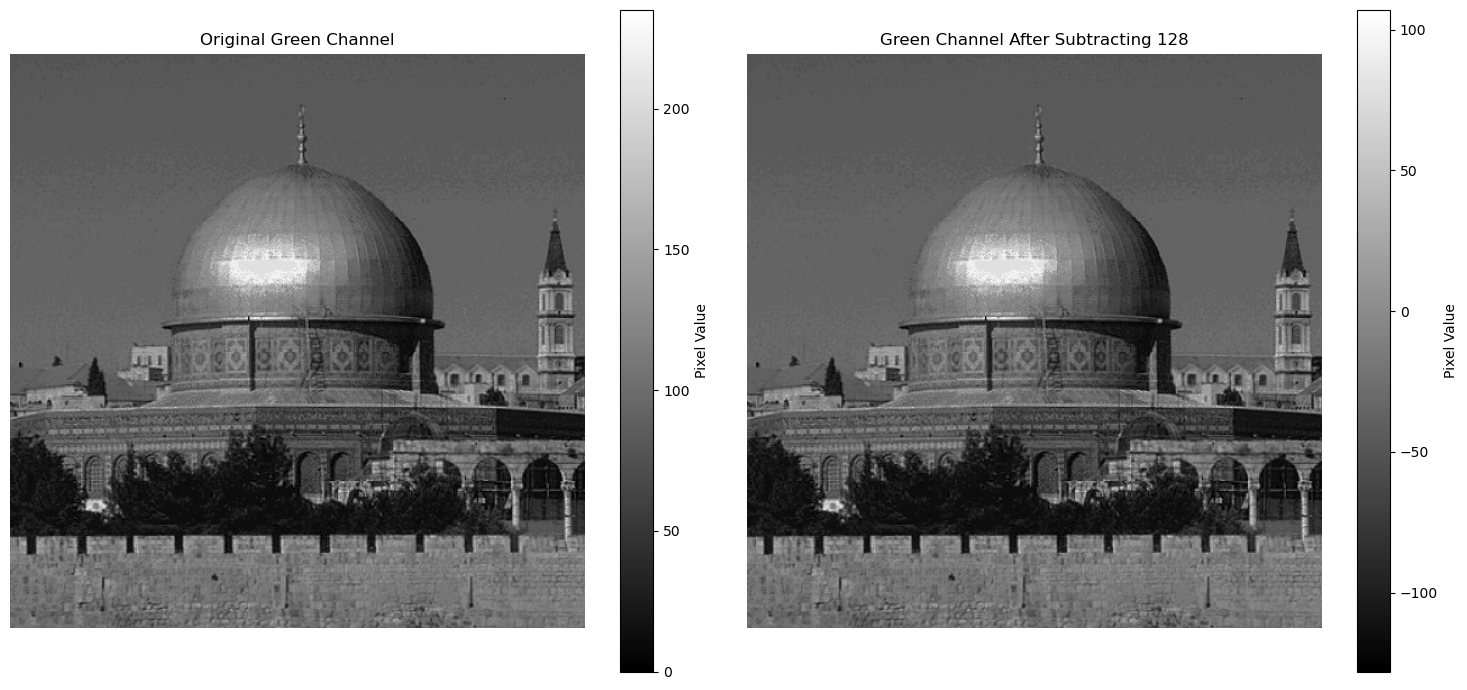

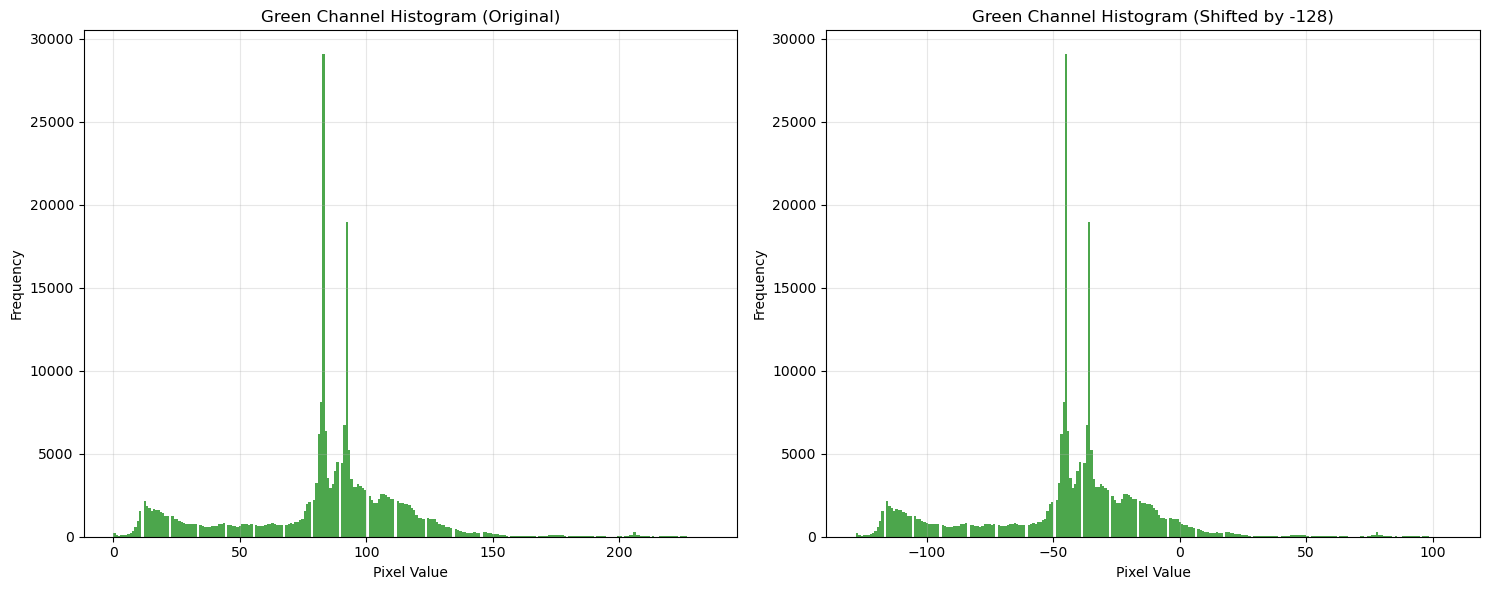

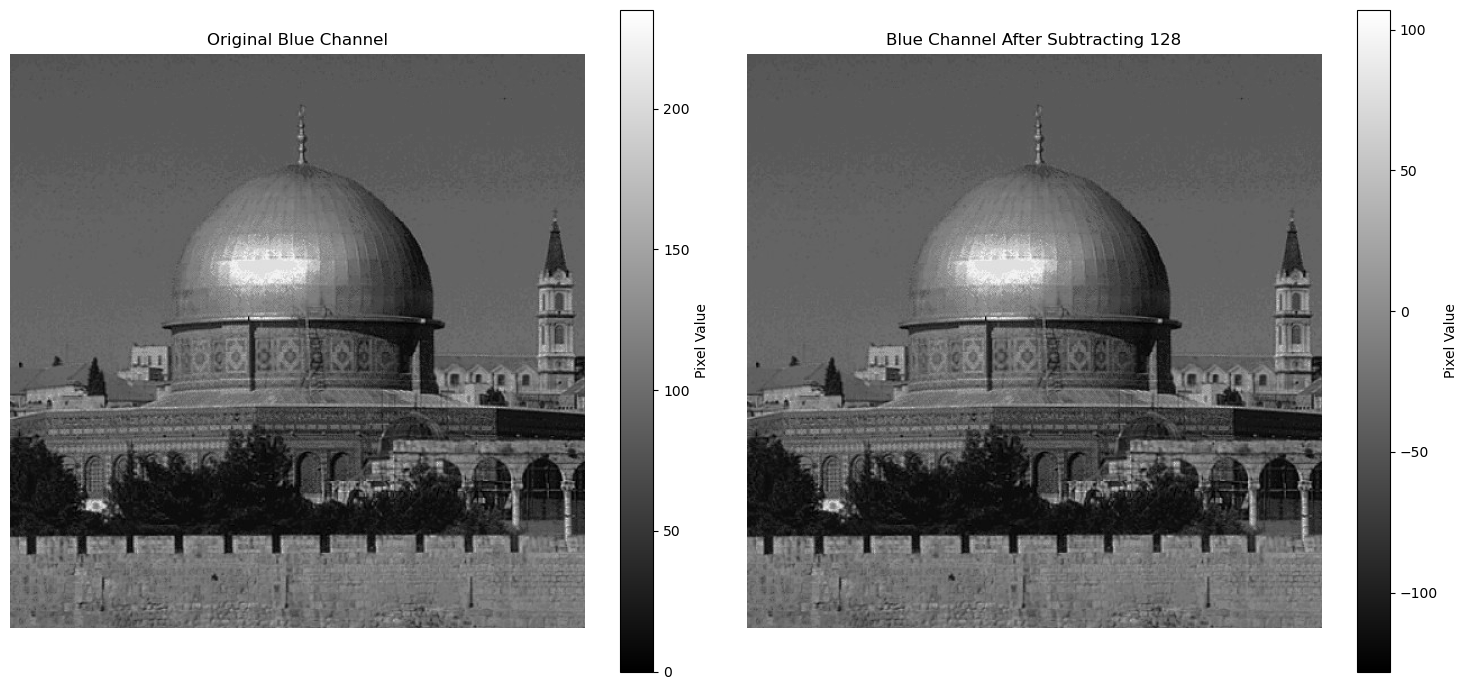

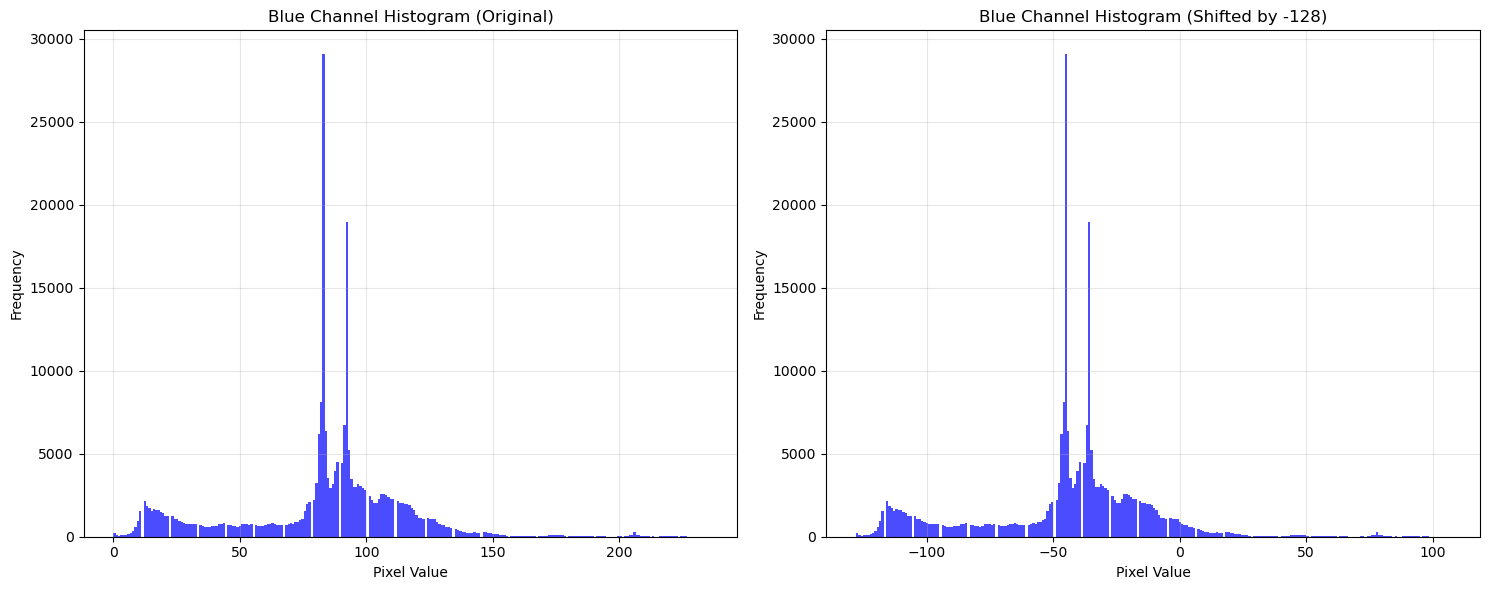

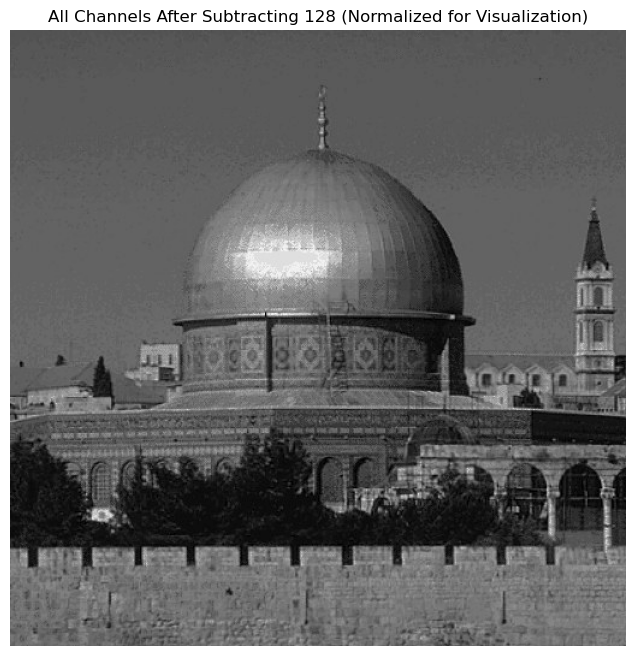

Compressing image using DCT and quantization...
Loading image: 1.jpg


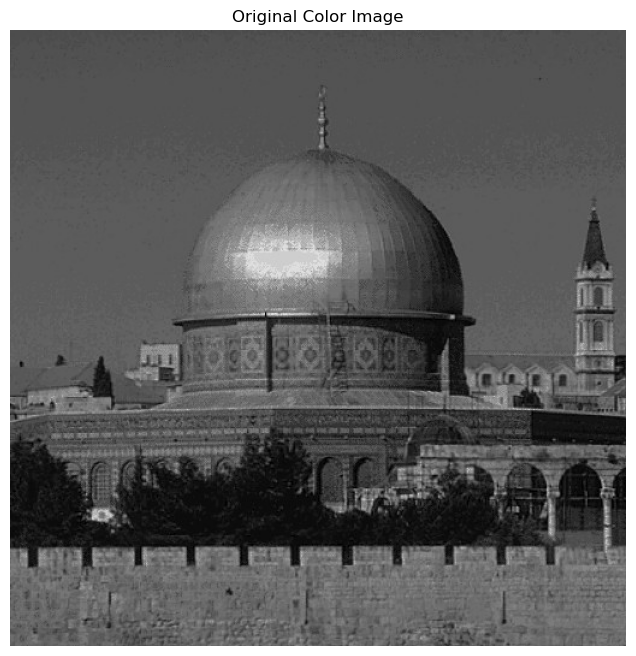

Original image size: 60.66 KB
Processing channel 0


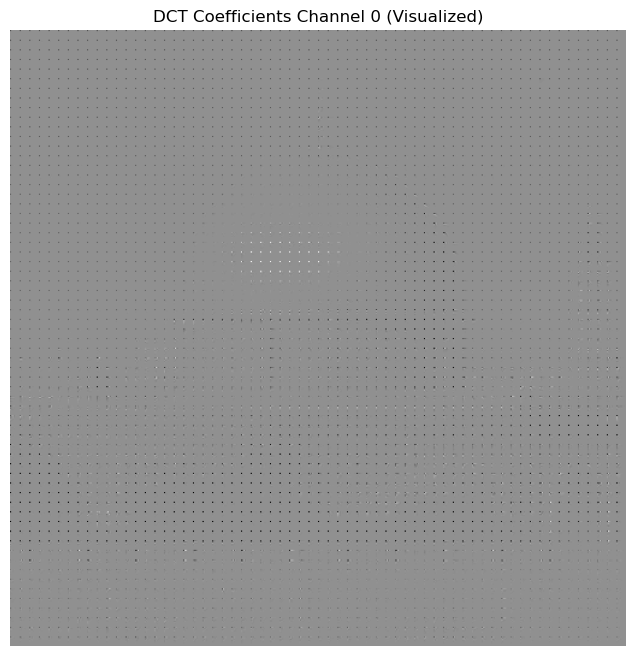

Processing channel 1


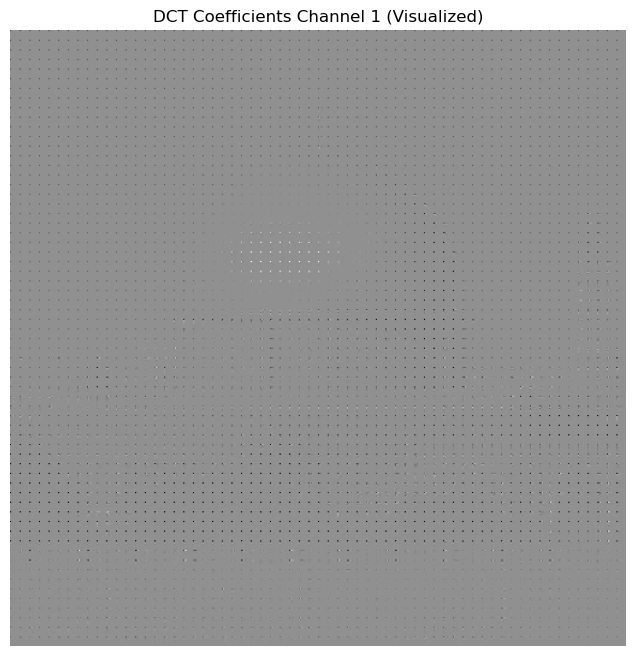

Processing channel 2


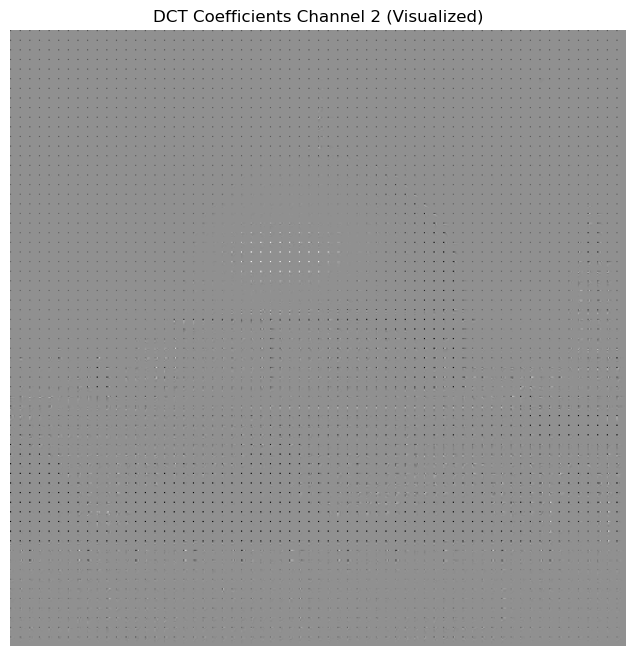

Saved DCT coefficients to .
Analyzing DCT coefficients...


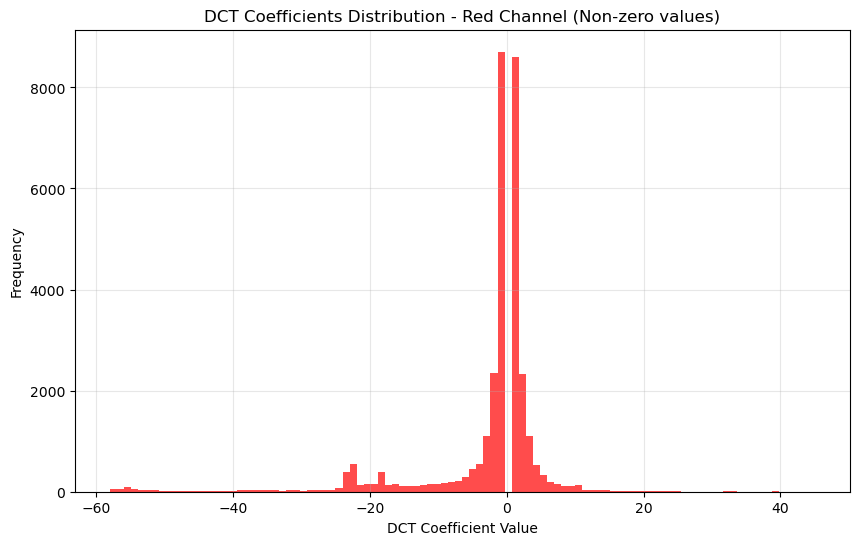

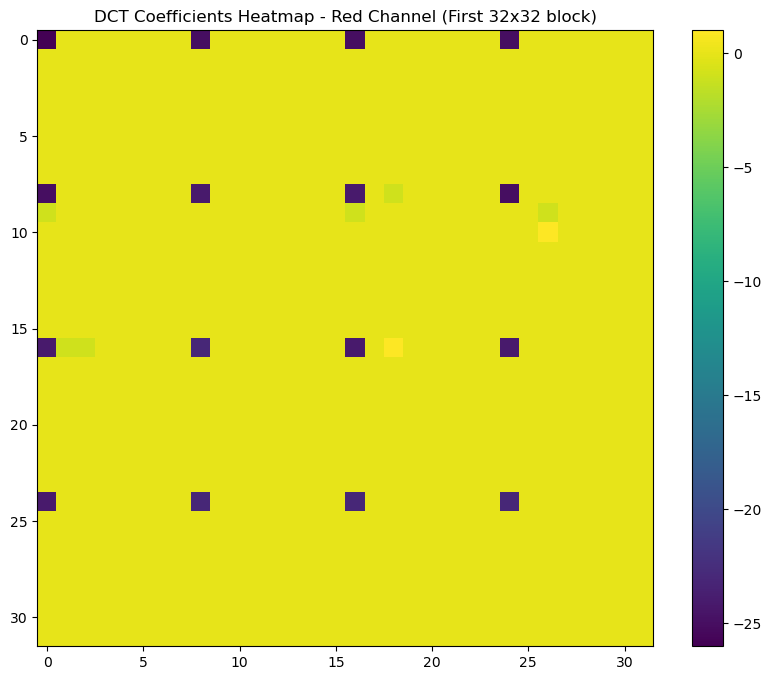

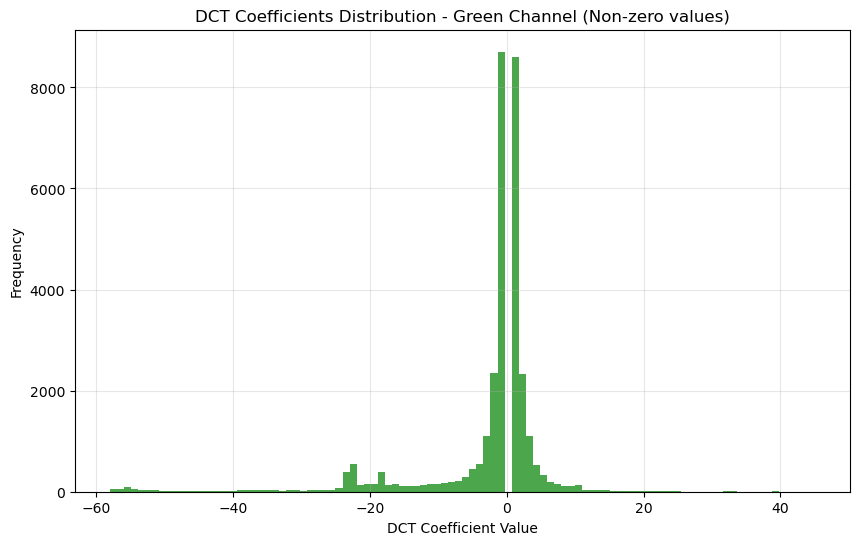

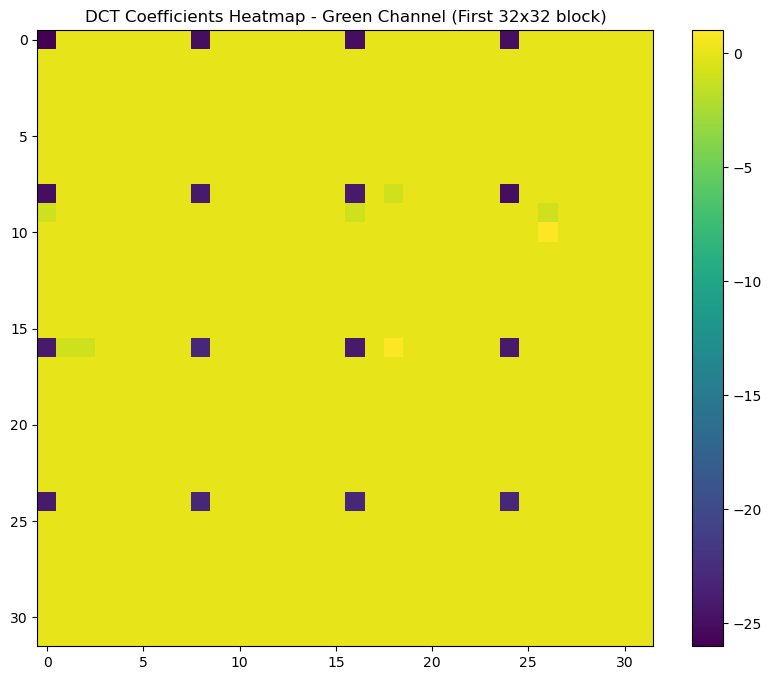

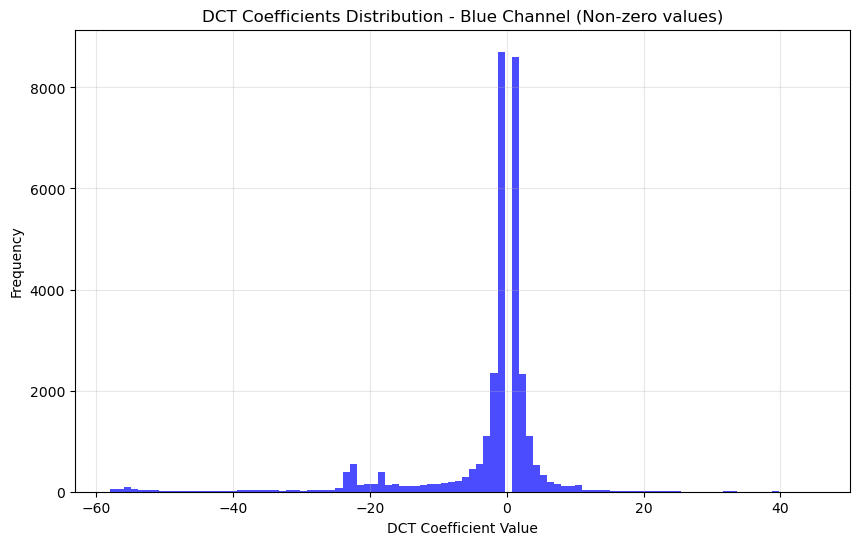

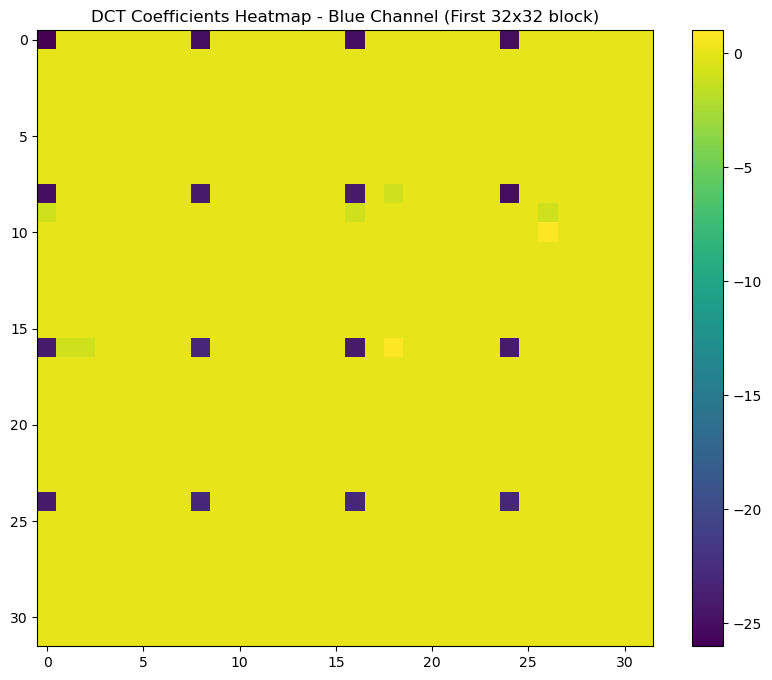


Compression Statistics:
Total pixels: 786432
Non-zero DCT coefficients: 95409 (12.13%)
Estimated compression ratio: 4.06:1

Decompressing image...
Decompressing image from DCT coefficients
Decompressing channel 0
Decompressing channel 1
Decompressing channel 2


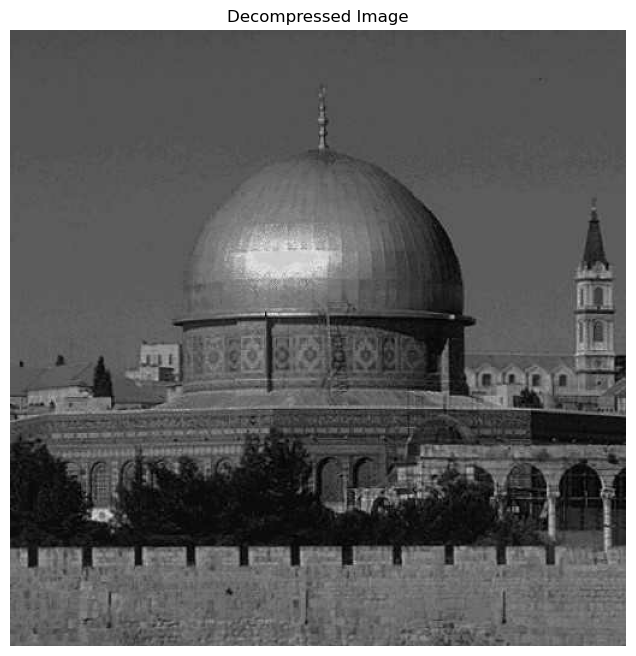

Saved decompressed image to decompressed_color_lena.jpg
Decompressed image size: 30.13 KB
Analyzing decompressed image...


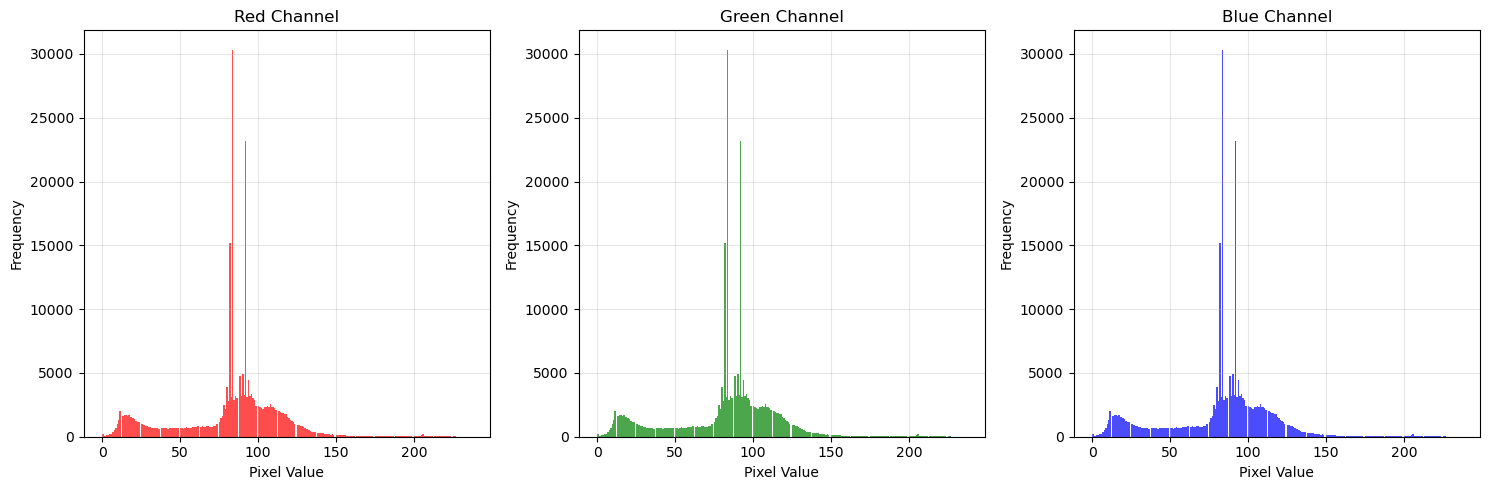


Mean Squared Error (MSE): 23.46
Peak Signal-to-Noise Ratio (PSNR): 34.43 dB

JPEG compression workflow completed successfully!


In [3]:
import numpy as np
from PIL import Image
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
import os

# Define the quantization matrix used in JPEG
Z = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# Display an image for debugging
def display_image(img_array, title="Image"):
    plt.figure(figsize=(8, 8))

    # Check if the image is color (3D array) or grayscale (2D array)
    if len(img_array.shape) == 3:
        plt.imshow(img_array.astype(np.uint8))
    else:
        plt.imshow(img_array, cmap='gray')

    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to apply DCT and quantization to an 8x8 block
def dct2(block):
    # Ensure the block is 8x8
    if block.shape[0] < 8 or block.shape[1] < 8:
        padded = np.zeros((8, 8))
        padded[:block.shape[0], :block.shape[1]] = block
        block = padded

    # Shift values by -128
    shifted = block - 128

    # Apply 2D DCT
    dct_applied = dct(dct(shifted, axis=0, norm='ortho'), axis=1, norm='ortho')

    # Quantize the coefficients
    quantized = np.round(dct_applied / Z)

    return quantized

# Function to perform inverse DCT and dequantization
def idct2(quantized_block):
    # Dequantize by multiplying with the quantization matrix
    dequantized = quantized_block * Z

    # Apply inverse 2D DCT
    idct_applied = idct(idct(dequantized, axis=0, norm='ortho'), axis=1, norm='ortho')

    # Shift back by adding 128 and clip to valid range [0, 255]
    result = np.clip(idct_applied + 128, 0, 255)

    return result

# Function to process a single channel
def process_channel(channel_array):
    height, width = channel_array.shape

    # Initialize result matrix for DCT coefficients
    dct_result = np.zeros((height, width), dtype=np.float32)

    # Process each 8x8 block
    for i in range(0, height, 8):
        for j in range(0, width, 8):
            # Get the current block (handling boundaries)
            i_end = min(i + 8, height)
            j_end = min(j + 8, width)
            block = channel_array[i:i_end, j:j_end]

            # Apply DCT and quantization
            dct_block = dct2(block)

            # Store in result
            dct_result[i:i_end, j:j_end] = dct_block[:i_end-i, :j_end-j]

    return dct_result

# Function to decompress a single channel
def decompress_channel(dct_coefficients):
    height, width = dct_coefficients.shape

    # Initialize array for restored channel
    restored = np.zeros((height, width), dtype=np.float32)

    # Process each 8x8 block
    for i in range(0, height, 8):
        for j in range(0, width, 8):
            # Get the current block (handling boundaries)
            i_end = min(i + 8, height)
            j_end = min(j + 8, width)

            # Extract block of DCT coefficients
            block = np.zeros((8, 8))
            block[:i_end-i, :j_end-j] = dct_coefficients[i:i_end, j:j_end]

            # Apply inverse DCT and dequantization
            idct_block = idct2(block)

            # Store in result
            restored[i:i_end, j:j_end] = idct_block[:i_end-i, :j_end-j]

    # Clip values to valid pixel range
    restored = np.clip(restored, 0, 255)

    return restored

# Function to compress a color image using JPEG-like process
def compress_image(image_path, output_dir="."):
    print(f"Loading image: {image_path}")

    # Load the image (keeping color)
    img = Image.open(image_path)

    # Display original image
    display_image(np.array(img), "Original Color Image")

    # Save original image info
    original_size = os.path.getsize(image_path)
    print(f"Original image size: {original_size / 1024:.2f} KB")

    # Convert to numpy array
    img_array = np.array(img, dtype=np.float32)

    # Check if the image is color or grayscale
    is_color = len(img_array.shape) == 3 and img_array.shape[2] >= 3

    if is_color:
        # Process each color channel separately
        height, width, channels = img_array.shape
        dct_results = []

        for c in range(3):  # Process RGB channels
            print(f"Processing channel {c}")
            channel = img_array[:, :, c]
            dct_channel = process_channel(channel)
            dct_results.append(dct_channel)

            # Visualize DCT coefficients (scaled for visibility)
            dct_vis = np.clip((dct_channel + 128), 0, 255).astype(np.uint8)
            display_image(dct_vis, f"DCT Coefficients Channel {c} (Visualized)")

            dct_img_path = os.path.join(output_dir, f"dct_visualized_channel_{c}.jpg")
            Image.fromarray(dct_vis).save(dct_img_path)

        # Combine channels for overall statistics
        dct_combined = np.stack(dct_results, axis=-1)

        # Save DCT coefficients for each channel
        for c in range(3):
            dct_path = os.path.join(output_dir, f"dct_coefficients_channel_{c}.txt")
            np.savetxt(dct_path, dct_results[c], fmt="%d")

        print(f"Saved DCT coefficients to {output_dir}")

        return dct_results
    else:
        # Fallback to grayscale processing for grayscale images
        print("Image is grayscale, processing single channel")
        return [process_channel(img_array)]

# Function to decompress a color image from DCT coefficients
def decompress_image(dct_coefficients, output_path="decompressed_color.jpg"):
    print("Decompressing image from DCT coefficients")

    # Check if we have multiple channels (color image)
    if isinstance(dct_coefficients, list) and len(dct_coefficients) > 1:
        # Process each color channel
        restored_channels = []

        for c, dct_channel in enumerate(dct_coefficients):
            print(f"Decompressing channel {c}")
            restored_channel = decompress_channel(dct_channel)
            restored_channels.append(restored_channel)

        # Combine channels to form RGB image
        restored = np.stack(restored_channels, axis=-1).astype(np.uint8)
    else:
        # Handle single channel case
        if isinstance(dct_coefficients, list):
            dct_channel = dct_coefficients[0]
        else:
            dct_channel = dct_coefficients

        restored = decompress_channel(dct_channel).astype(np.uint8)

    # Display decompressed image
    display_image(restored, "Decompressed Image")

    # Save decompressed image
    Image.fromarray(restored).save(output_path)
    print(f"Saved decompressed image to {output_path}")
    decompressed_size = os.path.getsize(output_path)
    print(f"Decompressed image size: {decompressed_size / 1024:.2f} KB")

    return restored

# Function to display histogram for a single channel
def display_histogram(data, title="Histogram", bins=256, color='blue'):
    plt.figure(figsize=(10, 6))
    plt.hist(data.flatten(), bins=bins, color=color, alpha=0.7)
    plt.title(title)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.show()

# Function to display histograms for all color channels
def display_color_histograms(img_array):
    # Check if image is color or grayscale
    is_color = len(img_array.shape) == 3 and img_array.shape[2] >= 3

    if is_color:
        # Display histograms for each channel
        channel_colors = ['red', 'green', 'blue']
        plt.figure(figsize=(15, 5))

        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.hist(img_array[:,:,i].flatten(), bins=256, color=channel_colors[i], alpha=0.7)
            plt.title(f'{channel_colors[i].capitalize()} Channel')
            plt.xlabel('Pixel Value')
            plt.ylabel('Frequency')
            plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        # Single histogram for grayscale
        display_histogram(img_array, "Grayscale Histogram")

# Function to display the effect of subtracting 128 from the data
def display_shifted_data(img_array, title_prefix=""):
    # Check if image is color or grayscale
    is_color = len(img_array.shape) == 3 and img_array.shape[2] >= 3

    if is_color:
        # Create full-sized shifted images for each channel
        shifted_channels = []
        channel_names = ['Red', 'Green', 'Blue']

        # First, display the original color image
        plt.figure(figsize=(10, 8))
        plt.imshow(img_array.astype(np.uint8))
        plt.title(f'{title_prefix} Original Color Image')
        plt.axis('off')
        plt.show()

        # Display each channel separately - original and shifted
        for c in range(3):
            # Create a figure with two images side by side
            plt.figure(figsize=(15, 7))

            # Original channel
            plt.subplot(1, 2, 1)
            plt.imshow(img_array[:,:,c], cmap='gray')
            plt.title(f'Original {channel_names[c]} Channel')
            plt.colorbar(label='Pixel Value')
            plt.axis('off')

            # Shifted channel (subtract 128)
            shifted = img_array[:,:,c] - 128
            plt.subplot(1, 2, 2)
            plt.imshow(shifted, cmap='gray')
            plt.title(f'{channel_names[c]} Channel After Subtracting 128')
            plt.colorbar(label='Pixel Value')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            # Store the shifted channel for later reconstruction
            shifted_channels.append(shifted)

            # Also display histograms of original and shifted data
            plt.figure(figsize=(15, 6))

            plt.subplot(1, 2, 1)
            plt.hist(img_array[:,:,c].flatten(), bins=256, color=channel_names[c].lower(), alpha=0.7)
            plt.title(f'{channel_names[c]} Channel Histogram (Original)')
            plt.xlabel('Pixel Value')
            plt.ylabel('Frequency')
            plt.grid(alpha=0.3)

            plt.subplot(1, 2, 2)
            plt.hist(shifted.flatten(), bins=256, color=channel_names[c].lower(), alpha=0.7)
            plt.title(f'{channel_names[c]} Channel Histogram (Shifted by -128)')
            plt.xlabel('Pixel Value')
            plt.ylabel('Frequency')
            plt.grid(alpha=0.3)

            plt.tight_layout()
            plt.show()

        # Try to visualize all shifted channels together (will look strange but informative)
        if len(shifted_channels) == 3:
            # Create a visualization by normalizing the shifted data to 0-255 range
            normalized_shifted = []
            for channel in shifted_channels:
                # Normalize to 0-255 range for visualization
                norm = ((channel - channel.min()) / (channel.max() - channel.min()) * 255).astype(np.uint8)
                normalized_shifted.append(norm)

            # Stack normalized channels to create RGB image
            shifted_rgb = np.stack(normalized_shifted, axis=-1)

            plt.figure(figsize=(10, 8))
            plt.imshow(shifted_rgb)
            plt.title('All Channels After Subtracting 128 (Normalized for Visualization)')
            plt.axis('off')
            plt.show()
    else:
        # For grayscale images
        plt.figure(figsize=(15, 7))

        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(img_array, cmap='gray')
        plt.title(f'{title_prefix} Original Grayscale Image')
        plt.colorbar(label='Pixel Value')
        plt.axis('off')

        # Shifted image (subtract 128)
        shifted = img_array - 128
        plt.subplot(1, 2, 2)
        plt.imshow(shifted, cmap='gray')
        plt.title(f'{title_prefix} Image After Subtracting 128')
        plt.colorbar(label='Pixel Value')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Display histograms
        plt.figure(figsize=(15, 6))

        plt.subplot(1, 2, 1)
        plt.hist(img_array.flatten(), bins=256, color='blue', alpha=0.7)
        plt.title('Original Histogram')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.grid(alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.hist(shifted.flatten(), bins=256, color='blue', alpha=0.7)
        plt.title('Shifted Histogram (-128)')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

# Function to visualize DCT coefficients distribution
def visualize_dct_distribution(dct_coefficients):
    if isinstance(dct_coefficients, list):
        # Handle multiple channels
        channel_names = ['Red', 'Green', 'Blue']

        for i, channel in enumerate(dct_coefficients[:3]):  # Process up to 3 channels
            plt.figure(figsize=(10, 6))

            # Plot histogram of DCT coefficients, excluding zeros for better visualization
            non_zero = channel[channel != 0].flatten()
            if len(non_zero) > 0:
                plt.hist(non_zero, bins=100, color=channel_names[i].lower(), alpha=0.7)
                plt.title(f'DCT Coefficients Distribution - {channel_names[i]} Channel (Non-zero values)')
                plt.xlabel('DCT Coefficient Value')
                plt.ylabel('Frequency')
                plt.grid(alpha=0.3)
                plt.show()

            # Show coefficient matrix heatmap
            plt.figure(figsize=(10, 8))
            sample_size = min(32, channel.shape[0], channel.shape[1])
            plt.imshow(channel[:sample_size, :sample_size], cmap='viridis')
            plt.colorbar()
            plt.title(f'DCT Coefficients Heatmap - {channel_names[i]} Channel (First {sample_size}x{sample_size} block)')
            plt.show()
    else:
        # Handle single channel
        plt.figure(figsize=(10, 6))

        # Plot histogram of DCT coefficients, excluding zeros
        non_zero = dct_coefficients[dct_coefficients != 0].flatten()
        if len(non_zero) > 0:
            plt.hist(non_zero, bins=100, color='blue', alpha=0.7)
            plt.title('DCT Coefficients Distribution (Non-zero values)')
            plt.xlabel('DCT Coefficient Value')
            plt.ylabel('Frequency')
            plt.grid(alpha=0.3)
            plt.show()

        # Show coefficient matrix heatmap
        plt.figure(figsize=(10, 8))
        sample_size = min(32, dct_coefficients.shape[0], dct_coefficients.shape[1])
        plt.imshow(dct_coefficients[:sample_size, :sample_size], cmap='viridis')
        plt.colorbar()
        plt.title(f'DCT Coefficients Heatmap (First {sample_size}x{sample_size} block)')
        plt.show()

# Huffman
def simulate_compression_stats(dct_coefficients):
    if isinstance(dct_coefficients, list):
        # Handle multiple channels
        total_pixels = 0
        non_zeros = 0

        for channel in dct_coefficients:
            total_pixels += channel.size
            non_zeros += np.count_nonzero(channel)
    else:
        # Handle single channel
        non_zeros = np.count_nonzero(dct_coefficients)
        total_pixels = dct_coefficients.size

    # Calculate percentage of non-zero coefficients
    non_zero_percent = (non_zeros / total_pixels) * 100

    # Estimate compression ratio based on typical JPEG behavior
    compression_ratio = 8 / (1 + non_zero_percent / 100 * 8)

    return {
        "total_pixels": total_pixels,
        "non_zero_coefficients": non_zeros,
        "non_zero_percent": non_zero_percent,
        "estimated_compression_ratio": compression_ratio
    }

# Main function to run the workflow
# Updated main function to incorporate histogram visualization
def main(image_path):
    print(f"Starting JPEG compression workflow on {image_path}")

    # Load the image
    img = Image.open(image_path)
    img_array = np.array(img, dtype=np.float32)

    # Step 0: Display original image and histograms
    print("Analyzing original image...")
    display_image(img_array, "Original Image")
    display_color_histograms(img_array)

    # Show what happens when we subtract 128 (level shifting)
    print("Visualizing pixel shifting (subtract 128)...")
    display_shifted_data(img_array, "Original Image")

    # Step 1: Compress image (DCT + Quantization)
    print("Compressing image using DCT and quantization...")
    dct_coefficients = compress_image(image_path)

    # Step 1.5: Visualize DCT coefficient distribution
    print("Analyzing DCT coefficients...")
    visualize_dct_distribution(dct_coefficients)

    # Step 2: Simulate compression statistics
    stats = simulate_compression_stats(dct_coefficients)
    print("\nCompression Statistics:")
    print(f"Total pixels: {stats['total_pixels']}")
    print(f"Non-zero DCT coefficients: {stats['non_zero_coefficients']} ({stats['non_zero_percent']:.2f}%)")
    print(f"Estimated compression ratio: {stats['estimated_compression_ratio']:.2f}:1")

    # Step 3: Decompress image
    print("\nDecompressing image...")
    restored_image = decompress_image(dct_coefficients, "decompressed_color_lena.jpg")

    # Step 4: Analyze decompressed image
    print("Analyzing decompressed image...")
    display_color_histograms(restored_image)

    # Step 5: Compare original and decompressed
    if isinstance(restored_image, np.ndarray) and isinstance(img_array, np.ndarray):
        if restored_image.shape == img_array.shape:
            # Calculate mean squared error between original and restored
            mse = np.mean((img_array - restored_image) ** 2)
            print(f"\nMean Squared Error (MSE): {mse:.2f}")

            # Calculate PSNR (Peak Signal-to-Noise Ratio)
            if mse > 0:
                psnr = 10 * np.log10((255 ** 2) / mse)
                print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr:.2f} dB")

    print("\nJPEG compression workflow completed successfully!")
    return dct_coefficients, restored_image

# Check if lena.jpg exists, otherwise use any .jpg file in the directory
image_path = "1.jpg"
if not os.path.exists(image_path):
    print(f"Warning: {image_path} not found!")
    jpg_files = [f for f in os.listdir(".") if f.lower().endswith(".jpg")]
    if jpg_files:
        image_path = jpg_files[0]
        print(f"Using {image_path} instead.")
    else:
        print("No .jpg files found. Please upload an image.")
        raise FileNotFoundError("No suitable image file found")

# Run the main workflow
dct_coefficients, restored_image = main(image_path)

In [8]:
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter import ttk
from PIL import Image, ImageTk
import numpy as np
import os
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

# Define the quantization matrix used in JPEG
Z = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# Function to display an image for debugging
def display_image(img_array, title="Image", cmap='gray'):
    plt.figure(figsize=(8, 8))
    plt.imshow(img_array, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.colorbar()
    plt.show()

# Function to apply DCT and quantization to an 8x8 block
def dct2(block):
    if block.shape[0] < 8 or block.shape[1] < 8:
        padded = np.zeros((8, 8))
        padded[:block.shape[0], :block.shape[1]] = block
        block = padded
    shifted = block - 128
    dct_applied = dct(dct(shifted, axis=0, norm='ortho'), axis=1, norm='ortho')
    quantized = np.round(dct_applied / Z)
    return quantized, shifted

# Function to apply inverse DCT and dequantization
def idct2(quantized_block):
    dequantized = quantized_block * Z
    idct_applied = idct(idct(dequantized, axis=0, norm='ortho'), axis=1, norm='ortho')
    result = np.clip(idct_applied + 128, 0, 255)
    return result

# Function to compress an image using JPEG-like process
def compress_image(image_path, output_dir="."):
    img = Image.open(image_path)
    img = img.convert('L')
    img_array = np.array(img, dtype=np.float32)
    preprocessed = img_array - 128
    height, width = img_array.shape
    dct_result = np.zeros((height, width), dtype=np.float32)
    preprocessed_result = np.zeros((height, width), dtype=np.float32)

    for i in range(0, height, 8):
        for j in range(0, width, 8):
            i_end = min(i + 8, height)
            j_end = min(j + 8, width)
            block = img_array[i:i_end, j:j_end]
            dct_block, shifted_block = dct2(block)
            dct_result[i:i_end, j:j_end] = dct_block[:i_end-i, :j_end-j]
            preprocessed_result[i:i_end, j:i_end] = shifted_block[:i_end-i, :j_end-j]

    return dct_result, preprocessed_result

# Function to decompress an image from DCT coefficients
def decompress_image(dct_coefficients, output_path="decompressed.jpg"):
    height, width = dct_coefficients.shape
    restored = np.zeros((height, width), dtype=np.float32)

    for i in range(0, height, 8):
        for j in range(0, width, 8):
            i_end = min(i + 8, height)
            j_end = min(j + 8, width)
            block = np.zeros((8, 8))
            block[:i_end-i, :j_end-j] = dct_coefficients[i:i_end, j:j_end]
            idct_block = idct2(block)
            restored[i:i_end, j:j_end] = idct_block[:i_end-i, :j_end-j]

    restored = np.clip(restored, 0, 255).astype(np.uint8)
    Image.fromarray(restored).save(output_path)
    return restored

# Function to simulate compression stats
def simulate_compression_stats(dct_coefficients):
    non_zeros = np.count_nonzero(dct_coefficients)
    total_pixels = dct_coefficients.size
    non_zero_percent = (non_zeros / total_pixels) * 100
    compression_ratio = 8 / (1 + non_zero_percent / 100 * 8)
    return {
        "total_pixels": total_pixels,
        "non_zero_coefficients": non_zeros,
        "non_zero_percent": non_zero_percent,
        "estimated_compression_ratio": compression_ratio
    }

# GUI class
class JPEGApp:
    def __init__(self, root):
        self.root = root
        self.root.title("JPEG Compression")

        self.image_path = None
        self.dct_coefficients = None
        self.preprocessed = None
        self.restored_image = None

        self.setup_ui()

    def setup_ui(self):
        self.upload_button = tk.Button(self.root, text="Upload Image", command=self.upload_image)
        self.upload_button.pack()

        self.compress_button = tk.Button(self.root, text="Compress Image", command=self.compress_image)
        self.compress_button.pack()

        self.decompress_button = tk.Button(self.root, text="Decompress Image", command=self.decompress_image)
        self.decompress_button.pack()

        self.stats_button = tk.Button(self.root, text="Show Stats", command=self.show_stats)
        self.stats_button.pack()

        self.save_button = tk.Button(self.root, text="Save Outputs", command=self.save_outputs)
        self.save_button.pack()

        self.image_label = tk.Label(self.root, text="No Image Loaded")
        self.image_label.pack()

        self.original_label = tk.Label(self.root, text="Original Image")
        self.original_label.pack()

        self.preprocessed_label = tk.Label(self.root, text="Preprocessed Image")
        self.preprocessed_label.pack()

        self.dct_label = tk.Label(self.root, text="DCT Image")
        self.dct_label.pack()

        self.restored_label = tk.Label(self.root, text="Decompressed Image")
        self.restored_label.pack()

    def upload_image(self):
        self.image_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg;*.png")])
        if self.image_path:
            self.image_label.config(text=f"Image: {os.path.basename(self.image_path)}")
            img = Image.open(self.image_path)
            img.thumbnail((250, 250))
            img = ImageTk.PhotoImage(img)
            self.image_label.config(image=img)
            self.image_label.image = img

    # Function to compress an image using JPEG-like process
    def compress_image(image_path, output_dir="."):
        img = Image.open(image_path)
        img = img.convert('L')  # Convert to grayscale
        img_array = np.array(img, dtype=np.float32)
        preprocessed = img_array - 128
        height, width = img_array.shape
        dct_result = np.zeros((height, width), dtype=np.float32)
        preprocessed_result = np.zeros((height, width), dtype=np.float32)

        # Loop through image in blocks of 8x8 pixels
        for i in range(0, height, 8):
            for j in range(0, width, 8):
                # Handle blocks that may be smaller than 8x8 at the image borders
                i_end = min(i + 8, height)
                j_end = min(j + 8, width)
                block = img_array[i:i_end, j:j_end]

                # Apply DCT and store results
                dct_block, shifted_block = dct2(block)
                dct_result[i:i_end, j:j_end] = dct_block[:i_end-i, :j_end-j]
                preprocessed_result[i:i_end, j:j_end] = shifted_block[:i_end-i, :j_end-j]

        return dct_result, preprocessed_result

    def decompress_image(self):
        if self.dct_coefficients is None:
            messagebox.showerror("Error", "No compressed image to decompress!")
            return
        self.restored_image = decompress_image(self.dct_coefficients)
        
        # Display the decompressed image
        restored_img = Image.fromarray(self.restored_image)
        restored_img.thumbnail((250, 250))
        restored_img = ImageTk.PhotoImage(restored_img)
        self.restored_label.config(image=restored_img)
        self.restored_label.image = restored_img

    def show_stats(self):
        if self.dct_coefficients is None:
            messagebox.showerror("Error", "No image compressed!")
            return
        stats = simulate_compression_stats(self.dct_coefficients)
        stats_text = f"Total Pixels: {stats['total_pixels']}\n"
        stats_text += f"Non-zero DCT Coefficients: {stats['non_zero_coefficients']} ({stats['non_zero_percent']:.2f}%)\n"
        stats_text += f"Estimated Compression Ratio: {stats['estimated_compression_ratio']:.2f}:1"
        messagebox.showinfo("Compression Stats", stats_text)

    def save_outputs(self):
        if self.restored_image is None:
            messagebox.showerror("Error", "No decompressed image to save!")
            return
        save_path = filedialog.asksaveasfilename(defaultextension=".jpg", filetypes=[("JPEG Files", "*.jpg")])
        if save_path:
            Image.fromarray(self.restored_image).save(save_path)
            messagebox.showinfo("Saved", f"Decompressed image saved to {save_path}")

# Main function to run the app
if __name__ == "__main__":
    root = tk.Tk()
    app = JPEGApp(root)
    root.mainloop()


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\hassa\anaconda3\Lib\site-packages\PIL\Image.py", line 3231, in open
    fp.seek(0)
    ^^^^^^^
AttributeError: 'JPEGApp' object has no attribute 'seek'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\hassa\anaconda3\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\hassa\AppData\Local\Temp\ipykernel_55032\177211767.py", line 157, in compress_image
    img = Image.open(image_path)
          ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\hassa\anaconda3\Lib\site-packages\PIL\Image.py", line 3233, in open
    fp = io.BytesIO(fp.read())
                    ^^^^^^^
AttributeError: 'JPEGApp' object has no attribute 'read'
